# Skin Cancer Classification
Note: The files used here are not attached to this repository.

In [1]:
# Load libraries
!pip install imblearn keras-tuner opencv-python
from tensorflow import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import random
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters as hp
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score, classification_report, roc_auc_score
from keras_tuner import Objective
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import cv2
import shutil
import os

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 6.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 6.5 MB/s eta 0:00:0000:01


2023-04-15 04:57:01.260664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 04:57:01.792127: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-15 04:57:03.072502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-15 04:57:03.072646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Num GPUs Available:  1


2023-04-15 04:57:06.214046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-15 04:57:06.293647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-15 04:57:06.294022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Constants

In [2]:
# Change this when you are running this yourself.
IMAGE_PATH = "/home/jovyan/work/ai/train"
OUTPUT_IMAGE_PATH_DOCKER = "/home/jovyan/work/tmp"
KERAS_IMAGE_CONFIG = (128, 128, 1) # 128 x 128, greyscale (1 channel)
KERAS_BATCH_SIZE = 16
IMAGE_FILENAME_COLUMN = "image_name"
TARGET_COLUMN = "target"
CLASS_MODE = "binary"
COLOUR_MODE = "grayscale"
TRUTH_FILE = "/home/jovyan/work/ai/ISIC_2020_Training_GroundTruth_v2.csv"
CANCEROUS = "malignant"
NON_CANCEROUS = "benign"

In [3]:
training_ground_truth = pd.read_csv(TRUTH_FILE)

# Data Preparation

In [4]:
# Null values
training_ground_truth.dropna(inplace=True)

In [5]:
# Add the `.jpg` extension
training_ground_truth[IMAGE_FILENAME_COLUMN] = training_ground_truth[IMAGE_FILENAME_COLUMN].apply(lambda x: f"{x}.jpg")

In [6]:
# Extract the target
training_ground_truth_y = training_ground_truth[TARGET_COLUMN]
training_ground_truth.drop(TARGET_COLUMN, axis=1, inplace=True)

In [7]:
# We only care about the image name and the target
training_ground_truth.drop(["patient_id", "lesion_id", "diagnosis", "sex", "age_approx", "anatom_site_general_challenge", "benign_malignant"], axis=1, inplace=True)

In [8]:
training_ground_truth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32531 entries, 0 to 33125
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  32531 non-null  object
dtypes: object(1)
memory usage: 508.3+ KB


In [9]:
training_ground_truth_y.info()

<class 'pandas.core.series.Series'>
Index: 32531 entries, 0 to 33125
Series name: target
Non-Null Count  Dtype
--------------  -----
32531 non-null  int64
dtypes: int64(1)
memory usage: 508.3 KB


# More Data Exploration Post-Cleaning

In [10]:
# Balanced undersampling
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=random.randint(0, 2**32 - 1))

undersampled_x, undersampled_y = undersampler.fit_resample(training_ground_truth, training_ground_truth_y)

In [11]:
# concatenate the variables and labels
undersampled_df = pd.concat([undersampled_x, undersampled_y], axis=1)

In [12]:
undersampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  1150 non-null   object
 1   target      1150 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.1+ KB


In [13]:
# Split into training and validation. The testing dataset is provided separately under "./testing" (or "./test"?)
# However, let's also split the training test further into train_df and temp_test_df. Maybe.

train_df, validate_df = train_test_split(undersampled_df, test_size=0.2, random_state=random.randint(0, 2**32 - 1), stratify=undersampled_df[TARGET_COLUMN])

train_df, test_df = train_test_split(train_df, test_size=0.2 / (0.6 + 0.2), random_state=random.randint(0, 2**32 - 1), stratify=train_df[TARGET_COLUMN])

print("Train, validate and test (the actual testing happens later) lengths:")
print(len(train_df))
print(len(validate_df))
print(len(test_df))

Train, validate and test (the actual testing happens later) lengths:
690
230
230


## Docker - Image Copying

In [14]:
def copy_images(df):
    src_dir = IMAGE_PATH
    dst_dir = OUTPUT_IMAGE_PATH_DOCKER
    
    # Check if the destination directory exists; if not, create it
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    for index, row in df.iterrows():
        image_name_to_copy = row[IMAGE_FILENAME_COLUMN]
        src_path = os.path.join(src_dir, image_name_to_copy)
        dst_path = os.path.join(dst_dir, image_name_to_copy)
        
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

In [15]:
# If in Docker:
# Change this if you are not running in Docker.
in_docker = True

if in_docker:
    copy_images(train_df)
    copy_images(validate_df)
    copy_images(test_df)
    IMAGE_PATH = OUTPUT_IMAGE_PATH_DOCKER

# Image Loading From Disk

In [16]:
# Note: Do not perform random transformations on the validation or testing set.
def load_images(df):
    temp_images = []
    
    for index, row in df.iterrows():
        image_name = row[IMAGE_FILENAME_COLUMN]
        temp_image = image.load_img(os.path.join(IMAGE_PATH, image_name), target_size=(KERAS_IMAGE_CONFIG[0], KERAS_IMAGE_CONFIG[1]), color_mode=COLOUR_MODE)
        temp_image_array = image.img_to_array(temp_image) / 255.0 # Normalising the image pixels
        temp_images.append(temp_image_array)
    
    return temp_images

In [17]:
train_images = load_images(train_df)

validation_images = load_images(validate_df)

test_images = load_images(test_df)

In [18]:
train_labels = train_df[TARGET_COLUMN]
validation_labels = validate_df[TARGET_COLUMN]
test_labels = test_df[TARGET_COLUMN]

In [19]:
print(len(train_images))
print(len(train_labels))

print(len(validation_images))
print(len(validation_labels))

print(len(test_images))
print(len(test_labels))

690
690
230
230
230
230


# Model Creation

In [20]:
def blur_image(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0) # Kernel size of 5 by 5, with a standard deviation of 0.
    return blurred_image.reshape(image.shape)

In [21]:
def add_noise(image):
    noise_factor = 0.025 # This could be changed in the future
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0.0, 1.0)
    return noisy_image.reshape(image.shape)

In [22]:
def combined_random_preprocessing(image):
    if random.random() < 0.3:
        image = blur_image(image)
        
    if random.random() < 0.3:
        image = add_noise(image)
        
    return image

In [23]:
def print_confusion_matrix(true_labels, predictions):
    temp_confusion_matrix = confusion_matrix(true_labels, predictions)
    
    # Calculate what percentage each class is equal to.
    temp_percentages = temp_confusion_matrix.astype("float") / temp_confusion_matrix.sum(axis=1)[:, np.newaxis]
    temp_percentages = np.round(temp_percentages * 100, 2) # Round to 2 decimal places
    
    # Also, as seaborn doesn't include the values by default, we need to add them
    confusion_matrix_labels = [["True Negative\n{}\n{}%".format(temp_confusion_matrix[0, 0], temp_percentages[0, 0]),
                                "False Positive\n{}\n{}%".format(temp_confusion_matrix[0, 1], temp_percentages[0, 1])],
                               ["False Negative\n{}\n{}%".format(temp_confusion_matrix[1, 0], temp_percentages[1, 0]),
                                "True Positive\n{}\n{}%".format(temp_confusion_matrix[1, 1], temp_percentages[1, 1])]]
    
    plt.figure(figsize=(6, 6))
    
    # Use Seaborn so we can add annotations
    sns.heatmap(temp_confusion_matrix, annot=confusion_matrix_labels, fmt="", cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [24]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * ((precision * recall) / (precision + recall + 1e-7)) # Prevent division by zero.
        return f1_score

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [25]:
train_data_generator = ImageDataGenerator(
    rotation_range=360,
    #preprocessing_function=combined_random_preprocessing,
    horizontal_flip=True,
    vertical_flip=True
) # no normalising here as that has already been done when loading the images from disk into memory

In [26]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)

## CNN - No Hyper-Parameters

In [67]:
# No hyper-parameters, following what `Introduction to convolutional neural network using Keras; an understanding from a statistician` did

initial_model = Sequential([
    Conv2D(filters=32,
           kernel_size=(3,3),
           activation="relu",
           input_shape=KERAS_IMAGE_CONFIG),
    Conv2D(filters=64,
           kernel_size=(3,3),
           activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(units=128, activation="relu"),
    Dropout(0.5),
    Dense(units=1, activation="sigmoid")
])

In [68]:
initial_model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])

In [69]:
print(initial_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 62, 62, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_5 (Dense)             (None, 128)               31490176  
                                                      

In [70]:
# Train
epochs = 15
initial_train_generator = train_data_generator.flow(np.array(train_images), np.array(train_labels), batch_size=KERAS_BATCH_SIZE)
initial_history = initial_model.fit(initial_train_generator, validation_data=(np.array(validation_images), np.array(validation_labels)), epochs=epochs, callbacks=[early_stopping])

Epoch 1/15
44/44 [==============================] - 3s 56ms/step - loss: 0.9511 - auc_2: 0.5113 - val_loss: 0.6925 - val_auc_2: 0.5389
Epoch 2/15
44/44 [==============================] - 2s 45ms/step - loss: 0.6876 - auc_2: 0.5498 - val_loss: 0.6888 - val_auc_2: 0.5764
Epoch 3/15
44/44 [==============================] - 2s 38ms/step - loss: 0.6807 - auc_2: 0.6171 - val_loss: 0.7015 - val_auc_2: 0.7000
Epoch 4/15
44/44 [==============================] - 2s 39ms/step - loss: 0.6860 - auc_2: 0.6152 - val_loss: 0.6893 - val_auc_2: 0.5909
Epoch 5/15
44/44 [==============================] - 2s 38ms/step - loss: 0.6842 - auc_2: 0.6045 - val_loss: 0.6924 - val_auc_2: 0.6579
Epoch 6/15
44/44 [==============================] - 2s 49ms/step - loss: 0.6771 - auc_2: 0.6516 - val_loss: 0.6867 - val_auc_2: 0.6298
Epoch 7/15
44/44 [==============================] - 2s 40ms/step - loss: 0.6761 - auc_2: 0.6288 - val_loss: 0.6888 - val_auc_2: 0.6738
Epoch 8/15
44/44 [==============================] - 2s 

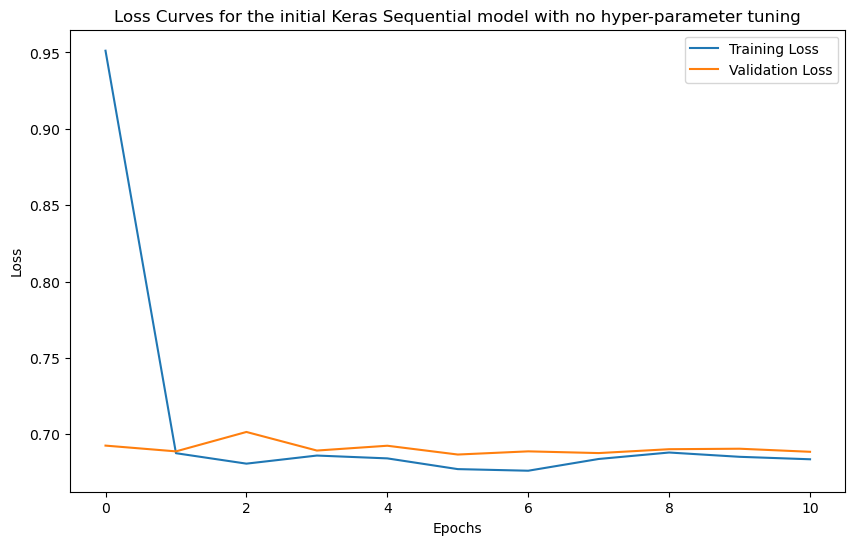

In [71]:
# Plot the loss curves for the initial model without hyper parameter tuning
plt.figure(figsize=(10, 6))

# Plot the loss curves

initial_training_loss = initial_history.history["loss"]
initial_validation_loss = initial_history.history["val_loss"]

plt.plot(initial_training_loss, label="Training Loss")
plt.plot(initial_validation_loss, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for the initial Keras Sequential model with no hyper-parameter tuning")
plt.legend()

plt.show()

In [72]:
# Make predictions using the initial model using the testing dataset
initial_model_predictions = initial_model.predict(np.array(test_images))
initial_model_prediction_labels = np.round(initial_model_predictions)

8/8 [==============================] - 0s 13ms/step


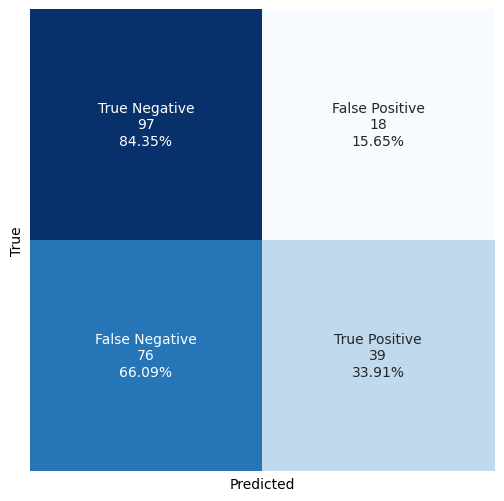

In [73]:
# Confusion Matrix
print_confusion_matrix(test_labels, initial_model_prediction_labels)

In [74]:
# Classification report
initial_classification_report = classification_report(test_labels, initial_model_prediction_labels)
print(initial_classification_report)

              precision    recall  f1-score   support

           0       0.56      0.84      0.67       115
           1       0.68      0.34      0.45       115

    accuracy                           0.59       230
   macro avg       0.62      0.59      0.56       230
weighted avg       0.62      0.59      0.56       230



## Adjusted Initial Model

In [36]:
adjusted_model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=KERAS_IMAGE_CONFIG),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1, activation="sigmoid")
])

In [37]:
adjusted_model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])

In [38]:
print(adjusted_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                      

In [39]:
# Train
adjusted_epochs = 50

adjusted_train_generator = train_data_generator.flow(np.array(train_images), np.array(train_labels), batch_size=KERAS_BATCH_SIZE)
adjusted_history = adjusted_model.fit(adjusted_train_generator, validation_data=(np.array(validation_images), np.array(validation_labels)), epochs=adjusted_epochs, callbacks=[early_stopping])

Epoch 1/50
44/44 [==============================] - 2s 33ms/step - loss: 0.8677 - auc_1: 0.6220 - val_loss: 0.8298 - val_auc_1: 0.6898
Epoch 2/50
44/44 [==============================] - 1s 24ms/step - loss: 0.8338 - auc_1: 0.6366 - val_loss: 0.6684 - val_auc_1: 0.6854
Epoch 3/50
44/44 [==============================] - 1s 23ms/step - loss: 0.7759 - auc_1: 0.6542 - val_loss: 0.6857 - val_auc_1: 0.6609
Epoch 4/50
44/44 [==============================] - 1s 24ms/step - loss: 0.6986 - auc_1: 0.7046 - val_loss: 0.6560 - val_auc_1: 0.6557
Epoch 5/50
44/44 [==============================] - 1s 23ms/step - loss: 0.7182 - auc_1: 0.6920 - val_loss: 0.7228 - val_auc_1: 0.6634
Epoch 6/50
44/44 [==============================] - 1s 23ms/step - loss: 0.6604 - auc_1: 0.7196 - val_loss: 0.7661 - val_auc_1: 0.6484
Epoch 7/50
44/44 [==============================] - 1s 23ms/step - loss: 0.7158 - auc_1: 0.6902 - val_loss: 0.9320 - val_auc_1: 0.6492
Epoch 8/50
44/44 [==============================] - 1s 

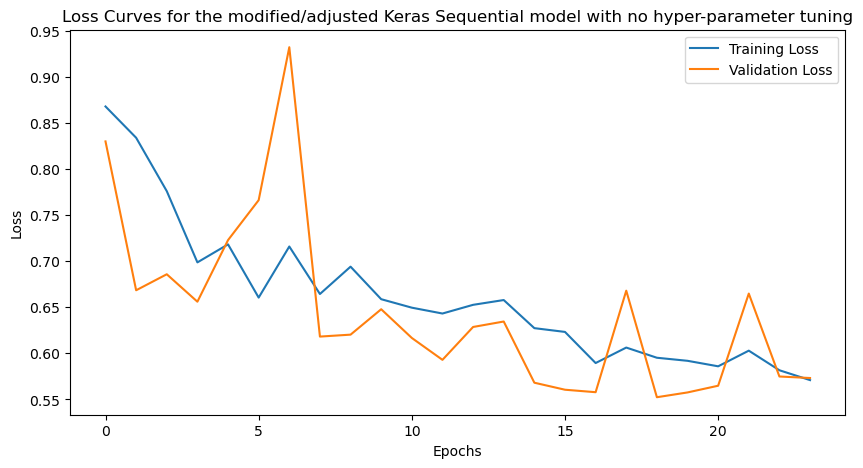

In [40]:
# Plot the loss curves for the initial model without hyper parameter tuning
plt.figure(figsize=(10, 5))

# Plot the loss curves

adjusted_training_loss = adjusted_history.history["loss"]
adjusted_validation_loss = adjusted_history.history["val_loss"]

plt.plot(adjusted_training_loss, label="Training Loss")
plt.plot(adjusted_validation_loss, label="Validation Loss")

# Set the labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for the modified/adjusted Keras Sequential model with no hyper-parameter tuning")
plt.legend()

# Display the plot
plt.show()

In [41]:
# Make predictions using the adjusted model using the testing dataset
adjusted_model_predictions = adjusted_model.predict(np.array(test_images))
adjusted_model_prediction_labels = np.round(adjusted_model_predictions)

8/8 [==============================] - 0s 7ms/step


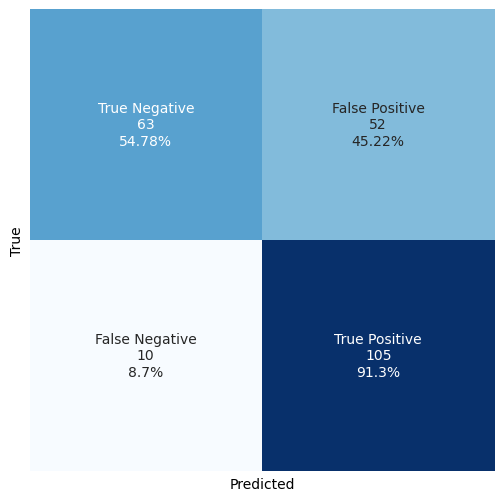

In [42]:
# Confusion Matrix
print_confusion_matrix(test_labels, adjusted_model_prediction_labels)

In [43]:
# Classification report
adjusted_classification_report = classification_report(test_labels, adjusted_model_prediction_labels)
print(adjusted_classification_report)

              precision    recall  f1-score   support

           0       0.86      0.55      0.67       115
           1       0.67      0.91      0.77       115

    accuracy                           0.73       230
   macro avg       0.77      0.73      0.72       230
weighted avg       0.77      0.73      0.72       230



## CNN - Hyper-Parameters

In [45]:
def build_model(hyper_params):
    hyper_model = Sequential()
    
    hyper_model.add(Conv2D(filters=hyper_params.Int(name="conv_1_filter", min_value=16, max_value=64, step=16),
                           kernel_size=hyper_params.Choice(name="conv_1_kernel", values=[3,5]),
                           activation="relu",
                           input_shape=KERAS_IMAGE_CONFIG)
                   )
    
    hyper_model.add(BatchNormalization())
    
    hyper_model.add(MaxPooling2D(pool_size=hyper_params.Int(name="pool_1_size", min_value=2, max_value=4, step=1)))
    
    hyper_model.add(Conv2D(filters=hyper_params.Int(name="conv_2_filter", min_value=32, max_value=64, step=16),
                           kernel_size=hyper_params.Choice(name="conv_2_kernel", values=[3,5]),
                           activation="relu",
                          )
                   )
    
    hyper_model.add(BatchNormalization())
    
    hyper_model.add(MaxPooling2D(pool_size=hyper_params.Int(name="pool_2_size", min_value=2, max_value=4, step=1)))
    
    hyper_model.add(Conv2D(filters=hyper_params.Int(name="conv_3_filter", min_value=64, max_value=128, step=32),
                           kernel_size=hyper_params.Choice(name="conv_3_kernel", values=[3,5]),
                           activation="relu",
                          )
                   )
    
    hyper_model.add(BatchNormalization())
    
    hyper_model.add(MaxPooling2D(pool_size=hyper_params.Int(name="pool_3_size", min_value=2, max_value=4, step=1)))
    
    hyper_model.add(Flatten())
    
    hyper_model.add(Dense(units=hyper_params.Int(name="dense_1_units", min_value=64, max_value=256, step=64), activation="relu"))
    
    hyper_model.add(BatchNormalization())
    
    hyper_model.add(Dropout(hyper_params.Float(name="dropout_1_rate", min_value=0.1, max_value=0.5, step=0.1)))
    
    hyper_model.add(Dense(units=hyper_params.Int(name="dense_2_units", min_value=64, max_value=128, step=32), activation="relu"))
    
    hyper_model.add(BatchNormalization())
    
    hyper_model.add(Dropout(hyper_params.Float(name="dropout_2_rate", min_value=0.1, max_value=0.5, step=0.1)))
    
    hyper_model.add(Dense(units=1, activation="sigmoid"))
    
    hyper_model.compile(optimizer=Adam(hyper_params.Choice(name="learning_rate", values=[1e-2, 1e-3, 1e-4])),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.AUC()])
    
    return hyper_model

In [46]:
hyper_tuner = RandomSearch(
    build_model,
    objective=Objective("val_auc", direction="max"), # Pontentially change this into a weighted sum of auc and f1
    max_trials=10,
    executions_per_trial=10,
    directory="./keras_tuner_new",
    project_name="sequential_hyper_params")

INFO:tensorflow:Reloading Tuner from ./keras_tuner_new/sequential_hyper_params/tuner0.json


In [47]:
hyper_tuner.search_space_summary()

Search space summary
Default search space size: 14
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
pool_1_size (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
pool_2_size (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
pool_3_size (Int)
{'default': None, 'conditions': [], 'min_value'

In [48]:
# Search for Hyper-Params
hyper_epochs = 20

hyper_train_generator = train_data_generator.flow(np.array(train_images), np.array(train_labels), batch_size=KERAS_BATCH_SIZE)

hyper_tuner.search(hyper_train_generator, epochs=hyper_epochs, validation_data=(np.array(validation_images), np.array(validation_labels)), callbacks=[early_stopping])

INFO:tensorflow:Oracle triggered exit


In [49]:
best_hyper_model = hyper_tuner.get_best_models(num_models=1)[0]
best_hyper_parameters = hyper_tuner.get_best_hyperparameters(num_trials=1)[0]

In [50]:
print("Best Hyper Parameters for the Keras Sequential model:")
for k, v in best_hyper_parameters.values.items():
    print(f"{k}\t: {v}")

Best Hyper Parameters for the Keras Sequential model:
conv_1_filter	: 48
conv_1_kernel	: 3
pool_1_size	: 2
conv_2_filter	: 64
conv_2_kernel	: 3
pool_2_size	: 4
conv_3_filter	: 64
conv_3_kernel	: 3
pool_3_size	: 2
dense_1_units	: 256
dropout_1_rate	: 0.5
dense_2_units	: 128
dropout_2_rate	: 0.30000000000000004
learning_rate	: 0.0001


In [51]:
# Make predictions using the adjusted model using the testing dataset
best_hyper_model_predictions = best_hyper_model.predict(np.array(test_images))
best_hyper_model_prediction_labels = np.round(best_hyper_model_predictions)

8/8 [==============================] - 0s 15ms/step


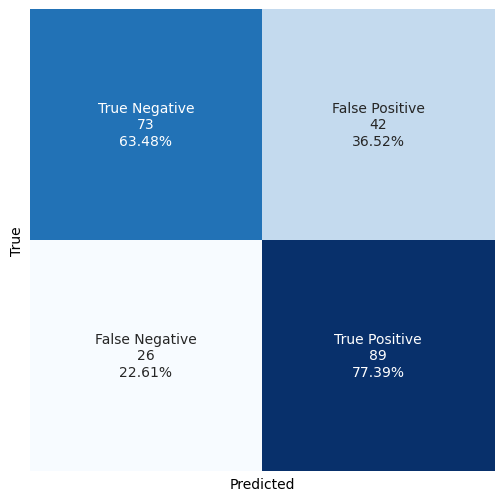

In [52]:
# Confusion Matrix
print_confusion_matrix(test_labels, best_hyper_model_prediction_labels)

In [53]:
# Classification report
best_hyper_classification_report = classification_report(test_labels, best_hyper_model_prediction_labels)
print(best_hyper_classification_report)

              precision    recall  f1-score   support

           0       0.74      0.63      0.68       115
           1       0.68      0.77      0.72       115

    accuracy                           0.70       230
   macro avg       0.71      0.70      0.70       230
weighted avg       0.71      0.70      0.70       230



In [54]:
# TODO: Save the model

# VGG16 Model

In [55]:
def crop_centre(image, target_width, target_height):
    whole_height, whole_width, _ = image.shape

    x_start = (whole_width // 2) - (target_width // 2)
    x_end = x_start + target_width

    y_start = (whole_height // 2) - (target_height // 2)
    y_end = y_start + target_height

    return image[y_start:y_end, x_start:x_end]

In [56]:
def load_vgg_images(df):  
    temp_images = []
    
    for index, row in df.iterrows():
        image_name = row[IMAGE_FILENAME_COLUMN]
        temp_image = image.load_img(os.path.join(IMAGE_PATH, image_name), color_mode="rgb")
        temp_image = np.array(temp_image)
        # Crop out the centre 224 by 224 of the image and use that, as those dimensions are what the model was initially trained on
        cropped_middle = crop_centre(temp_image, 224, 224)

        temp_images.append(cropped_middle)
    
    return temp_images

In [57]:
# Create the initial model
vgg_model_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 8s 0us/step


In [58]:
# Custom layers to perform binary classification
x = vgg_model_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x) # I think this is used to train new connections based on the images we now provide
vgg_output = Dense(1, activation="sigmoid")(x)

In [59]:
vgg_model = Model(inputs=vgg_model_base.input, outputs=vgg_output)

# Temporarily unfreeze
for layer in vgg_model_base.layers:
    layer.trainable = False

In [60]:
vgg_model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])

In [61]:
vgg_train_images = load_vgg_images(train_df)
vgg_validation_images = load_vgg_images(validate_df)
vgg_test_images = load_vgg_images(test_df)

In [62]:
# Train the VGG model on the new dataset briefly.
vgg_epochs = 10

vgg_train_generator = train_data_generator.flow(np.array(vgg_train_images), np.array(train_labels), batch_size=KERAS_BATCH_SIZE)

vgg_history = vgg_model.fit(vgg_train_generator, validation_data=(np.array(vgg_validation_images), np.array(validation_labels)), epochs=vgg_epochs, callbacks=[early_stopping])

Epoch 1/10


2023-04-15 05:01:29.731289: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-15 05:01:29.733586: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-15 05:01:30.079342: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-15 05:01:30.287722: W tensorflow/core/common_runtime/bfc_allocato

37/44 [========================>.....] - ETA: 0s - loss: 0.9469 - auc_1: 0.5893

2023-04-15 05:01:36.568502: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-15 05:01:36.681771: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-15 05:01:36.771892: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-15 05:01:36.902357: W tensorflow/core/common_runtime/bfc_allocato

44/44 [==============================] - ETA: 0s - loss: 0.8950 - auc_1: 0.6185

2023-04-15 05:01:38.920803: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


44/44 [==============================] - 15s 253ms/step - loss: 0.8950 - auc_1: 0.6185 - val_loss: 0.7697 - val_auc_1: 0.7120
Epoch 2/10
44/44 [==============================] - 8s 183ms/step - loss: 0.6923 - auc_1: 0.7123 - val_loss: 0.6703 - val_auc_1: 0.7185
Epoch 3/10
44/44 [==============================] - 8s 180ms/step - loss: 0.6371 - auc_1: 0.7438 - val_loss: 0.6680 - val_auc_1: 0.7183
Epoch 4/10
44/44 [==============================] - 9s 208ms/step - loss: 0.6819 - auc_1: 0.7339 - val_loss: 0.7569 - val_auc_1: 0.6988
Epoch 5/10
44/44 [==============================] - 7s 156ms/step - loss: 0.5580 - auc_1: 0.8014 - val_loss: 0.6901 - val_auc_1: 0.7049
Epoch 6/10
44/44 [==============================] - 7s 148ms/step - loss: 0.5129 - auc_1: 0.8198 - val_loss: 0.7266 - val_auc_1: 0.7226
Epoch 7/10
44/44 [==============================] - 6s 135ms/step - loss: 0.5783 - auc_1: 0.8008 - val_loss: 0.8303 - val_auc_1: 0.7268
Epoch 8/10
44/44 [==============================] - 6s 137

## VGG16 Model Predictions

In [63]:
vgg_predictions = vgg_model.predict(np.array(vgg_test_images))
vgg_prediction_labels = np.round(vgg_predictions)

8/8 [==============================] - 1s 140ms/step


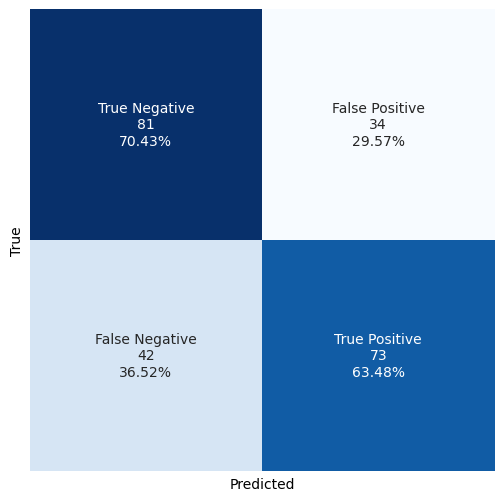

In [64]:
# Confusion Matrix
print_confusion_matrix(test_labels, vgg_prediction_labels)

In [65]:
# Classification report
vgg_classification_report = classification_report(test_labels, vgg_prediction_labels)
print(vgg_classification_report)

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       115
           1       0.68      0.63      0.66       115

    accuracy                           0.67       230
   macro avg       0.67      0.67      0.67       230
weighted avg       0.67      0.67      0.67       230



## AUC-ROC Scores For All Models

In [66]:
initial_auc_roc = roc_auc_score(test_labels, initial_model_prediction_labels)
print("AUC-ROC Score for Initial Model:", initial_auc_roc)

adjusted_auc_roc = roc_auc_score(test_labels, adjusted_model_prediction_labels)
print("AUC-ROC Score for Adjusted Model:", adjusted_auc_roc)

best_hyper_param_auc_roc = roc_auc_score(test_labels, best_hyper_model_prediction_labels)
print("AUC-ROC Score for the Best Hyper-Parameters Model:", best_hyper_param_auc_roc)

vgg_auc_roc = roc_auc_score(test_labels, vgg_prediction_labels)
print("AUC-ROC Score for VGG16 Model:", vgg_auc_roc)

AUC-ROC Score for Initial Model: 0.6217391304347826
AUC-ROC Score for Adjusted Model: 0.7304347826086957
AUC-ROC Score for the Best Hyper-Parameters Model: 0.7043478260869565
AUC-ROC Score for VGG16 Model: 0.6695652173913043
